## Import dependencies


In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Setup database


----RUN ONCE----


In [2]:
duckdb.query("INSTALL sqlite; LOAD sqlite;")
duckdb.query("ATTACH 'database.sqlite' AS my_data (TYPE sqlite);")

In [3]:
duckdb.query("CREATE VIEW Country AS SELECT * FROM my_data.Country;")
duckdb.query("CREATE VIEW League AS SELECT * FROM my_data.League;")
duckdb.query("CREATE VIEW Match AS SELECT * FROM my_data.Match;")
duckdb.query("CREATE VIEW Player AS SELECT * FROM my_data.Player;")
duckdb.query("CREATE VIEW Player_Attributes AS SELECT * FROM my_data.Player_Attributes;")
duckdb.query("CREATE VIEW Team AS SELECT * FROM my_data.Team;")
duckdb.query("CREATE VIEW Team_Attributes AS SELECT * FROM my_data.Team_Attributes;")

----RUN ONCE----


## Explore database


In [4]:
tables = duckdb.query("SELECT view_name FROM duckdb_views;").to_df()["view_name"]
duckdb.query("SELECT view_name, column_count FROM duckdb_views;")

┌───────────────────┬──────────────┐
│     view_name     │ column_count │
│      varchar      │    int64     │
├───────────────────┼──────────────┤
│ Country           │            2 │
│ League            │            3 │
│ Match             │          115 │
│ Player            │            7 │
│ Player_Attributes │           42 │
│ Team              │            5 │
│ Team_Attributes   │           25 │
└───────────────────┴──────────────┘

In [5]:
for table in tables:
    print(f"'{table}' table's schema:")
    display(duckdb.query(f"PRAGMA table_info({table})"))

'Country' table's schema:


┌───────┬─────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │  name   │  type   │ notnull │ dflt_value │   pk    │
│ int32 │ varchar │ varchar │ boolean │  varchar   │ boolean │
├───────┼─────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id      │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ name    │ VARCHAR │ false   │ NULL       │ false   │
└───────┴─────────┴─────────┴─────────┴────────────┴─────────┘

'League' table's schema:


┌───────┬────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │    name    │  type   │ notnull │ dflt_value │   pk    │
│ int32 │  varchar   │ varchar │ boolean │  varchar   │ boolean │
├───────┼────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id         │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ country_id │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ name       │ VARCHAR │ false   │ NULL       │ false   │
└───────┴────────────┴─────────┴─────────┴────────────┴─────────┘

'Match' table's schema:


┌───────┬──────────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │       name       │  type   │ notnull │ dflt_value │   pk    │
│ int32 │     varchar      │ varchar │ boolean │  varchar   │ boolean │
├───────┼──────────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id               │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ country_id       │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ league_id        │ BIGINT  │ false   │ NULL       │ false   │
│     3 │ season           │ VARCHAR │ false   │ NULL       │ false   │
│     4 │ stage            │ BIGINT  │ false   │ NULL       │ false   │
│     5 │ date             │ VARCHAR │ false   │ NULL       │ false   │
│     6 │ match_api_id     │ BIGINT  │ false   │ NULL       │ false   │
│     7 │ home_team_api_id │ BIGINT  │ false   │ NULL       │ false   │
│     8 │ away_team_api_id │ BIGINT  │ false   │ NULL       │ false   │
│     9 │ home_team_goal   │ BIGINT  │ false   │ NULL       │ fa

'Player' table's schema:


┌───────┬────────────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │        name        │  type   │ notnull │ dflt_value │   pk    │
│ int32 │      varchar       │ varchar │ boolean │  varchar   │ boolean │
├───────┼────────────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id                 │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ player_api_id      │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ player_name        │ VARCHAR │ false   │ NULL       │ false   │
│     3 │ player_fifa_api_id │ BIGINT  │ false   │ NULL       │ false   │
│     4 │ birthday           │ VARCHAR │ false   │ NULL       │ false   │
│     5 │ height             │ BIGINT  │ false   │ NULL       │ false   │
│     6 │ weight             │ BIGINT  │ false   │ NULL       │ false   │
└───────┴────────────────────┴─────────┴─────────┴────────────┴─────────┘

'Player_Attributes' table's schema:


┌───────┬─────────────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │        name         │  type   │ notnull │ dflt_value │   pk    │
│ int32 │       varchar       │ varchar │ boolean │  varchar   │ boolean │
├───────┼─────────────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id                  │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ player_fifa_api_id  │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ player_api_id       │ BIGINT  │ false   │ NULL       │ false   │
│     3 │ date                │ VARCHAR │ false   │ NULL       │ false   │
│     4 │ overall_rating      │ BIGINT  │ false   │ NULL       │ false   │
│     5 │ potential           │ BIGINT  │ false   │ NULL       │ false   │
│     6 │ preferred_foot      │ VARCHAR │ false   │ NULL       │ false   │
│     7 │ attacking_work_rate │ VARCHAR │ false   │ NULL       │ false   │
│     8 │ defensive_work_rate │ VARCHAR │ false   │ NULL       │ false   │
│     9 │ crossing       

'Team' table's schema:


┌───────┬──────────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │       name       │  type   │ notnull │ dflt_value │   pk    │
│ int32 │     varchar      │ varchar │ boolean │  varchar   │ boolean │
├───────┼──────────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id               │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ team_api_id      │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ team_fifa_api_id │ BIGINT  │ false   │ NULL       │ false   │
│     3 │ team_long_name   │ VARCHAR │ false   │ NULL       │ false   │
│     4 │ team_short_name  │ VARCHAR │ false   │ NULL       │ false   │
└───────┴──────────────────┴─────────┴─────────┴────────────┴─────────┘

'Team_Attributes' table's schema:


┌───────┬────────────────────────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │              name              │  type   │ notnull │ dflt_value │   pk    │
│ int32 │            varchar             │ varchar │ boolean │  varchar   │ boolean │
├───────┼────────────────────────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ id                             │ BIGINT  │ false   │ NULL       │ false   │
│     1 │ team_fifa_api_id               │ BIGINT  │ false   │ NULL       │ false   │
│     2 │ team_api_id                    │ BIGINT  │ false   │ NULL       │ false   │
│     3 │ date                           │ VARCHAR │ false   │ NULL       │ false   │
│     4 │ buildUpPlaySpeed               │ BIGINT  │ false   │ NULL       │ false   │
│     5 │ buildUpPlaySpeedClass          │ VARCHAR │ false   │ NULL       │ false   │
│     6 │ buildUpPlayDribbling           │ BIGINT  │ false   │ NULL       │ false   │
│     7 │ buildUpPlayDribblingClass      │ VARCHAR │ f

In [6]:
duckdb.query("""
    SELECT 'Country' AS table_name, COUNT(1) AS row_count 
    FROM Country

    UNION

    SELECT 'League' AS table_name, COUNT(1) AS row_count 
    FROM League

    UNION

    SELECT 'Team' AS table_name, COUNT(1) AS row_count 
    FROM Team

    UNION
    
    SELECT 'Team_Attributes' AS table_name, COUNT(1) AS row_count 
    FROM Team_Attributes

    UNION
    
    SELECT 'Player' AS table_name, COUNT(1) AS row_count 
    FROM Player
    
    UNION
    
    SELECT 'Player_Attributes' AS table_name, COUNT(1) AS row_count 
    FROM Player_Attributes

    UNION
    
    SELECT 'Match' AS table_name, COUNT(1) AS row_count 
    FROM Match
    """)

┌───────────────────┬───────────┐
│    table_name     │ row_count │
│      varchar      │   int64   │
├───────────────────┼───────────┤
│ Country           │        11 │
│ League            │        11 │
│ Team              │       299 │
│ Team_Attributes   │      1458 │
│ Player            │     11060 │
│ Player_Attributes │    183978 │
│ Match             │     25979 │
└───────────────────┴───────────┘

## Feature engineering and clean-up


In [7]:
duckdb.query("SELECT * FROM Country")

┌───────┬─────────────┐
│  id   │    name     │
│ int64 │   varchar   │
├───────┼─────────────┤
│     1 │ Belgium     │
│  1729 │ England     │
│  4769 │ France      │
│  7809 │ Germany     │
│ 10257 │ Italy       │
│ 13274 │ Netherlands │
│ 15722 │ Poland      │
│ 17642 │ Portugal    │
│ 19694 │ Scotland    │
│ 21518 │ Spain       │
│ 24558 │ Switzerland │
├───────┴─────────────┤
│ 11 rows   2 columns │
└─────────────────────┘

In [8]:
duckdb.query("SELECT * FROM League")

┌───────┬────────────┬──────────────────────────┐
│  id   │ country_id │           name           │
│ int64 │   int64    │         varchar          │
├───────┼────────────┼──────────────────────────┤
│     1 │          1 │ Belgium Jupiler League   │
│  1729 │       1729 │ England Premier League   │
│  4769 │       4769 │ France Ligue 1           │
│  7809 │       7809 │ Germany 1. Bundesliga    │
│ 10257 │      10257 │ Italy Serie A            │
│ 13274 │      13274 │ Netherlands Eredivisie   │
│ 15722 │      15722 │ Poland Ekstraklasa       │
│ 17642 │      17642 │ Portugal Liga ZON Sagres │
│ 19694 │      19694 │ Scotland Premier League  │
│ 21518 │      21518 │ Spain LIGA BBVA          │
│ 24558 │      24558 │ Switzerland Super League │
├───────┴────────────┴──────────────────────────┤
│ 11 rows                             3 columns │
└───────────────────────────────────────────────┘

Let's check if there's any null values.


In [9]:
def get_columns_from_duckdb_table(table: str):
    return duckdb.query(f"""
            SELECT *
            FROM {table}
            LIMIT 1
            """).to_df().columns

In [10]:
# RUN ONCE
duckdb.query("""
    CREATE MACRO COUNT_NULL(a) AS
    SUM(CASE WHEN a IS NULL THEN 1 ELSE 0 END);
    """)

In [11]:
# for table in tables:
#     nulls = []
#     for column in get_columns_from_duckdb_table(table):
#         nulls.append(duckdb.query(f"""
#             SELECT COUNT_NULL("{column}")
#             FROM {table}
#             """).to_df().values[0][0])
#     print(f"Total nulls in {table} table: {sum(nulls)}")

### Which leagues are in which countries?


In [12]:
duckdb.query("""
    SELECT l.name league, c.name country
    FROM League l
    INNER JOIN Country c
    ON l.country_id = c.id
""")

┌──────────────────────────┬─────────────┐
│          league          │   country   │
│         varchar          │   varchar   │
├──────────────────────────┼─────────────┤
│ Belgium Jupiler League   │ Belgium     │
│ England Premier League   │ England     │
│ France Ligue 1           │ France      │
│ Germany 1. Bundesliga    │ Germany     │
│ Italy Serie A            │ Italy       │
│ Netherlands Eredivisie   │ Netherlands │
│ Poland Ekstraklasa       │ Poland      │
│ Portugal Liga ZON Sagres │ Portugal    │
│ Scotland Premier League  │ Scotland    │
│ Spain LIGA BBVA          │ Spain       │
│ Switzerland Super League │ Switzerland │
├──────────────────────────┴─────────────┤
│ 11 rows                      2 columns │
└────────────────────────────────────────┘

### Which leagues score the most/fewest goals?


In [13]:
from functions import *

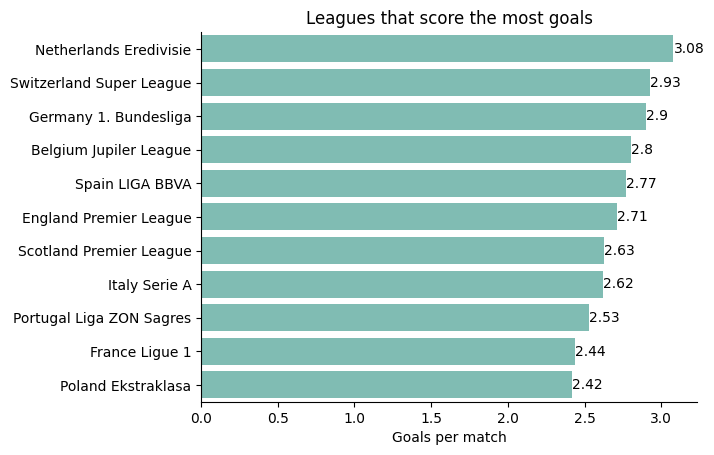

In [14]:
league_goals = duckdb.query("""
    SELECT L.name League, SUM(m.home_team_goal+m.away_team_goal) goals, COUNT(*) matches, ROUND(goals/matches,2) "Goals per match"
    FROM League L
    INNER JOIN Match m
    ON L.id = m.league_id
    GROUP BY L.name
    ORDER BY "Goals per match" DESC
""").to_df()

sns.barplot(data=league_goals, x="Goals per match", y="League", color = figure_colors[4])
plt.title("Leagues that score the most goals")
plt.ylabel("")
for container in plt.gca().containers:
    plt.gca().bar_label(container)
sns.despine()

### Who are the top scorers in each team and league?


In [ ]:
duckdb.